In [1]:
import os
import numpy
import re
import random
from scipy.stats import gaussian_kde, pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.transforms as mtransforms
import math
import matplotlib.pyplot as plt

WORK_SPACE = os.getcwd()

In [2]:
PIXEL_PAIRS_MAX = 1000


def identifer(data):
    down,up = numpy.nanpercentile(data,[0,75])
    IQR = up-down
    lower_limit = down - 1.5*IQR
    upper_limit = up + 1.5*IQR
    result = numpy.where(data > upper_limit,numpy.nan, data)
    result = numpy.where(result < lower_limit,numpy.nan, result)
    return result


def add_right_cax(ax, pad, width):

    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(axpos.x1 + pad, axpos.y0, axpos.x1 + pad + width, axpos.y1)
    cax = ax.figure.add_axes(caxpos)

    return cax


def mapping_scatter(Y, X, figure_title='demo', band_name='band3', axis_min=0.0, axis_max=0.5, save_flag=0):
    # filter    
#     if band_name == 'band3':
#         axis_max = 0.3
    
    lim_x = numpy.copy(X)
    lim_y = numpy.copy(Y)

    up4_x = numpy.quantile(lim_x, 0.98, interpolation='higher')
    up4_y = numpy.quantile(lim_y, 0.98, interpolation='higher')
    lim_x[lim_x > up4_x] = numpy.nan
    lim_y[lim_y > up4_y] = numpy.nan

    lim_mask = (lim_x*lim_y)*0+1
    temp_x = lim_x*lim_mask
    temp_y = lim_y*lim_mask
    temp_x = temp_x[~numpy.isnan(temp_x)]
    temp_y = temp_y[~numpy.isnan(temp_y)]
    
    diff_array = abs(numpy.array(temp_y)-numpy.array(temp_x))/abs(numpy.minimum(numpy.array(temp_x), numpy.array(temp_y)))
    diff_array_filtered = numpy.array(identifer(diff_array))
    show_x = (diff_array_filtered*0+1)*temp_x
    show_y = (diff_array_filtered*0+1)*temp_y
    
    x_o = show_x[~numpy.isnan(show_x)]
    y_o = show_y[~numpy.isnan(show_y)]

    fig = plt.figure(figsize=(4, 4))
    ax1 = fig.add_subplot(111, aspect='equal',facecolor='whitesmoke', alpha=0.1)
    ax1.grid(linestyle='--', linewidth=0.3)

    model = LinearRegression()
    x = x_o.reshape(-1, 1)
    model.fit(x, y_o)
    y_pred = model.predict(x)
    xx = numpy.arange(axis_min, axis_max + 0.1, 0.05)
    k = model.coef_[0]
    b = model.intercept_
    yy = k * xx + b
    
    N = len(x_o)
    x = numpy.arange(axis_min, axis_max + 1)
    y = 1 * x

#     g_x, g_y = numpy.mgrid[axis_min:axis_max:500j, axis_min:axis_max:500j]
#     positions = numpy.vstack([g_x.ravel(), g_y.ravel()])
#     values = numpy.vstack([X, Y])
#     kernel = gaussian_kde(values)
#     Z = numpy.reshape(kernel(positions).T, g_x.shape)
    
    # Calculate the point density
    xy = numpy.vstack([x_o, y_o])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x_, y_, z = x_o[idx], y_o[idx], z[idx]
    z = (z-numpy.min(z))/(numpy.max(z)-numpy.min(z))*100
    im = ax1.scatter(x_, y_, marker='o', c=z, s=8, cmap='turbo')
    
    # Calculate parameters
    r2 = r2_score(y_o, x_o)
    rmse = numpy.sqrt(mean_squared_error(y_o, x_o))
    rmse_r = (rmse/numpy.mean(x_o))*100 # %
    bias = numpy.mean(y_o-x_o)
    bias_r = (bias/numpy.mean(x_o))*100 # %
    r_, p = pearsonr(x_o, y_o)
    p_str = '%.3e' % p
    
    print('R²:', r2)
    print('relative RMSE (%):', rmse_r)
    print('RMSE:', rmse)
    print('relative Bias (%):', bias_r)
    print('Bias:', bias)
    print('r_:', bias)    

    ax1.minorticks_on()
    x_major_locator = plt.MultipleLocator(0.1)
    x_minor_locator = plt.MultipleLocator(0.05)
    ticks_interval = 0.1
    if band_name == 'band4':
        x_major_locator = plt.MultipleLocator(0.2)
        x_minor_locator = plt.MultipleLocator(0.1)
        ticks_interval = 0.2
    ax1.xaxis.set_minor_locator(x_minor_locator)
    ax1.xaxis.set_major_locator(x_major_locator)
    ax1.yaxis.set_minor_locator(x_minor_locator)
    ax1.yaxis.set_major_locator(x_major_locator)
    ax1.set_xticks(numpy.arange(axis_min, axis_max + ticks_interval, ticks_interval))
    ax1.set_yticks(numpy.arange(axis_min+ticks_interval, axis_max-ticks_interval, ticks_interval))

    ax1.tick_params(axis="y", which='minor', length=3, direction='in', labelsize=15)
    ax1.tick_params(axis="y", which='major', length=5, direction='in', labelsize=15)

    ax1.tick_params(axis="x", which='minor', length=3, direction='in', labelsize=15)
    ax1.tick_params(axis="x", which='major', length=5, direction='in', labelsize=15)

    # ax1.spines['right'].set_color('none')
    # ax1.spines['top'].set_color('none')
    ax1.spines['left'].set_linewidth(1)
    ax1.spines['bottom'].set_linewidth(1)


    band_label = {
        'band3': 'Band3',
        'band4': 'Band4',
    }

    ax1.set_ylabel("AHI LSR", fontsize=15)
    ax1.set_xlabel("MISR LSR", fontsize=15)

#     ax1.imshow(numpy.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[axis_min, axis_max, axis_min, axis_max], alpha=0.8, zorder=0)
#     ax1.plot(X, Y, 'k.', markersize=0.5, alpha=0.8, zorder=4)
    ax1.plot(x, y, color='k', linewidth=1, linestyle='-', zorder=1)
    ax1.plot(xx, yy, color='r', linewidth=1, linestyle='-.', zorder=2)
    
#     label_str = 'y = {}x + {}\nRMSE = {}\nr = {}\n'.format(round(k, 2), round(b, 2), round(rmse, 3), round(r_, 2))
#     if b < 0:
#         label_str = 'y = {}x - {}\nRMSE = {}\nr = {}\n'.format(round(k, 2), abs(round(b, 2)), round(rmse, 3), round(r_, 2))

#     text_x = axis_min + (axis_max - axis_min) * 0.07
#     text_y = axis_max - (axis_max - axis_min) * 0.35
#     ax1.text(text_x, text_y, s=label_str, fontsize=18)
    
#     band_label = band_label[band_name]
#     text_x2 = axis_min + (axis_max - axis_min) * 0.7
#     text_y2 = axis_min + (axis_max - axis_min) * 0.1
#     if band_name == 'band3':
#         ax1.text(text_x2, text_y2, color='red', s=band_label, fontsize=18)
#     else:
#         ax1.text(text_x2, text_y2, color='firebrick', s=band_label, fontsize=18)
    
    label_str = 'y = {}x + {}\nRRMSE: {}%\nRbias: {}%\nr: {}'.format(round(k, 2), round(b, 2), round(rmse_r, 2), round(bias_r, 2),round(r_, 2))
    if b < 0:
        label_str = 'y = {}x + {}\nRRMSE: {}%\nRbias: {}%\nr: {}'.format(round(k, 2), round(b, 2), round(rmse_r, 2), round(bias_r, 2),round(r_, 2))

    text_x = axis_min+(axis_max - axis_min)*0.024
    text_y = axis_max-(axis_max - axis_min)*0.368
    ax1.text(text_x, text_y, s=label_str, fontsize=18)
            
    label_str2 = 'R²: {}\nbias: {}\nRMSE: {}\n'.format(round(r2, 2), round(bias, 3), round(rmse, 3))
    text_x2 = axis_max-(axis_max - axis_min)*0.02
    text_y2 = axis_min-(axis_max - axis_min)*0.06
    ax1.text(text_x2, text_y2, s=label_str2, fontsize=18, horizontalalignment='right')

    cax = add_right_cax(ax1, pad=0.01, width=0.03)
    cb = fig.colorbar(im, cax=cax)
    
    ax1.set_xlim(axis_min, axis_max)
    ax1.set_ylim(axis_min, axis_max)
    
    mapping_folder = os.path.join(WORK_SPACE, 'year_scatter_LC_SR_south_re')
    figure_folder = os.path.join(mapping_folder, str(PIXEL_PAIRS_MAX))
    if not os.path.exists(figure_folder):
        os.makedirs(figure_folder)
    fig_filename = os.path.join(figure_folder, figure_title + '.png')
    fig.savefig(fig_filename, dpi=1000, bbox_inches='tight')
    print(fig_filename)
    plt.show()
    plt.clf()
    
    # slope r RMSE
    return k, r_, rmse

Random NO.: 1000
45 0
MISR_SR_Band3_NO. AHI_SR_Band3_NO. MISR_SR_Band4_NO. AHI_SR_Band4_NO.
1548 1548 1548 1548
R²: 0.8712213626705425
relative RMSE (%): 11.210494708626749
RMSE: 0.015285336984949011
relative Bias (%): 3.398162629760628
Bias: 0.004633342441665936
r_: 0.004633342441665936
/disk1/workspace/20230725/RAA_30S40S/RAA/year_scatter_LC_SR_south_re/1000/45_0_b3_1000.png


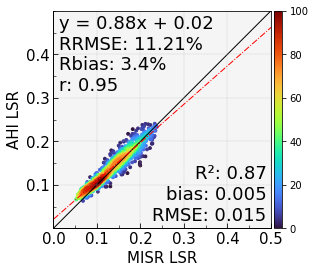

R²: 0.7822306937713243
relative RMSE (%): 8.982414285424294
RMSE: 0.03317791318392482
relative Bias (%): 1.3441434778055568
Bias: 0.0049647983488956835
r_: 0.0049647983488956835
/disk1/workspace/20230725/RAA_30S40S/RAA/year_scatter_LC_SR_south_re/1000/45_0_b4_1000.png


<Figure size 432x288 with 0 Axes>

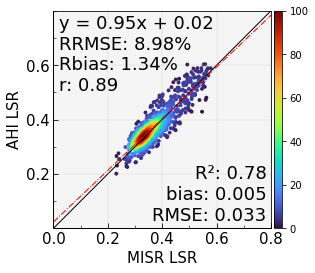

Random NO.: 1000
45 1
MISR_SR_Band3_NO. AHI_SR_Band3_NO. MISR_SR_Band4_NO. AHI_SR_Band4_NO.
1998 1998 1998 1998
R²: 0.7350932059970596
relative RMSE (%): 12.524745573899704
RMSE: 0.008409349611594156
relative Bias (%): -2.6917715187037468
Bias: -0.0018073059960980592
r_: -0.0018073059960980592
/disk1/workspace/20230725/RAA_30S40S/RAA/year_scatter_LC_SR_south_re/1000/45_1_b3_1000.png


<Figure size 432x288 with 0 Axes>

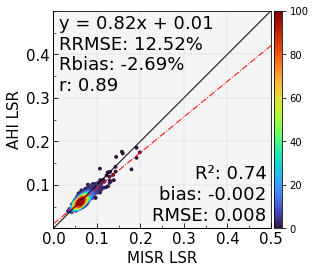

R²: 0.3149384328129561
relative RMSE (%): 9.578440963724812
RMSE: 0.03502138138941164
relative Bias (%): 6.1968440091722785
Bias: 0.02265734458016837
r_: 0.02265734458016837
/disk1/workspace/20230725/RAA_30S40S/RAA/year_scatter_LC_SR_south_re/1000/45_1_b4_1000.png


<Figure size 432x288 with 0 Axes>

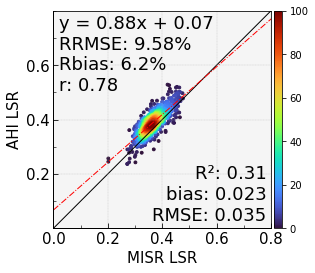

<Figure size 432x288 with 0 Axes>

In [5]:
if __name__ == "__main__":

    # folder_l1_list = ['0', '26', '45', '60', '70']
    # folder_l2_list = ['0', '1']
    folder_l1_list = ['45']
    folder_l2_list = ['0', '1']
    lc_type = ['10', '2']
    month_idxs = [4, 5, 6, 7]

    for folder_l1 in folder_l1_list:
        folder_l1_path = os.path.join(WORK_SPACE, folder_l1)
        for folder_l2 in folder_l2_list:
            # each png
            misr_SR_band3_item_list = []
            ahi_SR_band3_item_list = []
            misr_SR_band4_item_list = []
            ahi_SR_band4_item_list = []
            folder_l2_path = os.path.join(folder_l1_path, folder_l2)
            roi_folder_list = os.listdir(folder_l2_path)
            for roi_folder in roi_folder_list:
                roi_infos = roi_folder.split('_')
                roi_lc = roi_infos[1]
                folder_l2_idx = int(folder_l2)
                obj_lc = lc_type[folder_l2_idx]
                if roi_lc == obj_lc:
                    roi_lat = float(roi_infos[2])
                    if roi_lat < 0:   # only south
                        roi_folder_path = os.path.join(folder_l2_path, roi_folder)
                        roi_file_list = os.listdir(roi_folder_path)
                        roi_misr_SR_band3_list = []
                        roi_ahi_SR_band3_list = []
                        roi_misr_SR_band4_list = []
                        roi_ahi_SR_band4_list = []
                        for roi_file in roi_file_list:
                            matchObj = re.search(r'(\d+)_band(\d+)_(\d+).npy', str(roi_file))
                            if matchObj:
                                ahi_time_str = matchObj.group(1)
                                month_idx = int(ahi_time_str[4:6])-1
                                if month_idx in month_idxs:
                                    band_str = matchObj.group(2)
                                    # camera_idx_str = matchObj.group(3)
                                    SR_npy_path = os.path.join(roi_folder_path, roi_file)
                                    ROI_SR_pair = numpy.load(SR_npy_path, allow_pickle=True)[0]
                                    misr_sr = ROI_SR_pair['misr_v3']
                                    ahi_sr = ROI_SR_pair['ahi_sr2misr']
                                    x_3Darray_np_1d = misr_sr.flatten()
                                    x_3Darray_np_1d = x_3Darray_np_1d[~numpy.isnan(x_3Darray_np_1d)]
                                    y_3Darray_np_1d = ahi_sr.flatten()
                                    y_3Darray_np_1d = y_3Darray_np_1d[~numpy.isnan(y_3Darray_np_1d)]
                                    if band_str == '3':
                                        roi_misr_SR_band3_list.extend(x_3Darray_np_1d)
                                        roi_ahi_SR_band3_list.extend(y_3Darray_np_1d)
                                    if band_str == '4':
                                        roi_misr_SR_band4_list.extend(x_3Darray_np_1d)
                                        roi_ahi_SR_band4_list.extend(y_3Darray_np_1d)
                        # keep pixel count same
                        if len(roi_misr_SR_band3_list) == len(roi_misr_SR_band4_list):
                            misr_SR_band3_item_list.extend(roi_misr_SR_band3_list)
                            ahi_SR_band3_item_list.extend(roi_ahi_SR_band3_list)
                            misr_SR_band4_item_list.extend(roi_misr_SR_band4_list)
                            ahi_SR_band4_item_list.extend(roi_ahi_SR_band4_list)

            print('Random NO.:', PIXEL_PAIRS_MAX)
            print(folder_l1, folder_l2)
            print('MISR_SR_Band3_NO.', 'AHI_SR_Band3_NO.', 'MISR_SR_Band4_NO.', 'AHI_SR_Band4_NO.')
            print(len(misr_SR_band3_item_list), len(ahi_SR_band3_item_list), len(misr_SR_band4_item_list), len(ahi_SR_band4_item_list))

            if len(misr_SR_band3_item_list) > PIXEL_PAIRS_MAX:
                # random pairs mapping
                index_array = random.sample([idx for idx in range(len(misr_SR_band3_item_list))], PIXEL_PAIRS_MAX)
                index_array = numpy.sort(index_array).tolist()

                misr_SR_band3_pts = numpy.array(misr_SR_band3_item_list)
                show_misr_sr_b3 = misr_SR_band3_pts[index_array]
                ahi_SR_band3_pts = numpy.array(ahi_SR_band3_item_list)
                show_ahi_sr_b3 = ahi_SR_band3_pts[index_array]
                figure_title = folder_l1 + '_' + folder_l2 + '_b3' + '_' + str(PIXEL_PAIRS_MAX)
                mapping_scatter(show_ahi_sr_b3, show_misr_sr_b3, figure_title, 'band3', axis_min=0.0, axis_max=0.5)

                misr_SR_band4_pts = numpy.array(misr_SR_band4_item_list)
                show_misr_sr_b4 = misr_SR_band4_pts[index_array]
                ahi_SR_band4_pts = numpy.array(ahi_SR_band4_item_list)
                show_ahi_sr_b4 = ahi_SR_band4_pts[index_array]
                figure_title = folder_l1 + '_' + folder_l2 + '_b4' + '_' + str(PIXEL_PAIRS_MAX)
                mapping_scatter(show_ahi_sr_b4, show_misr_sr_b4, figure_title, 'band4', axis_min=0.0, axis_max=0.8)

            else:
                # all pairs mapping
                pairs_no = len(misr_SR_band3_item_list)
                if pairs_no > 3:

                    misr_SR_band3_pts = numpy.array(misr_SR_band3_item_list)
                    ahi_SR_band3_pts = numpy.array(ahi_SR_band3_item_list)
                    figure_title = folder_l1 + '_' + folder_l2 + '_b3' + '_' + str(pairs_no)
                    mapping_scatter(ahi_SR_band3_pts, misr_SR_band3_pts, figure_title, 'band3', axis_min=0.0, axis_max=0.5)

                    misr_SR_band4_pts = numpy.array(misr_SR_band4_item_list)
                    ahi_SR_band4_pts = numpy.array(ahi_SR_band4_item_list)
                    figure_title = folder_l1 + '_' + folder_l2 + '_b4' + '_' + str(pairs_no)
                    mapping_scatter(ahi_SR_band4_pts, misr_SR_band4_pts, figure_title, 'band4', axis_min=0.0, axis_max=0.8)